In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h5py
import os
import time
from random import sample
import datetime
from collections import Counter
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'Northwestern/Artificial Intelligence and Deep Learning/Assignment 3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from tensorflow.keras.datasets import reuters

voc_size = 10000

(train_data_raw, train_labels_raw), (test_data_raw, test_labels_raw) = reuters.load_data(num_words=voc_size)
word_index = reuters.get_word_index()
train_data_raw.shape, test_data_raw.shape

557056/550378 [==============================] - 0s 0us/step


((8982,), (2246,))

In [0]:
def explore_data():

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    doc_indexes = sample(range(len(train_data_raw)), 10)
    for doc_index in doc_indexes:    
        decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_raw[doc_index]])
        print(decoded_newswire)

        print('Number of words in document:', len(decoded_newswire.split()))
        print('Number of encodings in sample:', len(train_data_raw[doc_index]))

In [19]:
explore_data()

? spectra physics inc said its board rejected a 32 dlrs per share unsolicited tender offer for the company's stock from ciba geigy ltd lt ? z which already holds 18 8 pct of the stock spectra physics said it also filed a lawsuit in delaware federal court this morning seeking to enjoin the offer and alleging among other things that the offer ? federal securities laws certain agreements between ciba geigy and spectra physics and ciba ? fiduciary duties spectra physics said the two ciba geigy ? to its board were not present at yesterday's special meeting which voted to reject the offer as financially inadequate unfair and not in the best interests of spectra physics or its stockholders the company said the board also authorized a special committee of outside directors to take whatever steps it ? necessary to protect the interests of spectra physics and its stockholders and to investigate all alternatives to maximize the value of the stock including talks with third parties spectra physics

In [7]:
max([len(set(lst)) for lst in train_data_raw])

530

In [6]:
Counter(train_labels_raw).most_common(10)

[(3, 3159),
 (4, 1949),
 (19, 549),
 (16, 444),
 (1, 432),
 (11, 390),
 (20, 269),
 (13, 172),
 (8, 139),
 (10, 124)]

In [0]:
Counter(test_labels_raw).most_common(10)

[(3, 813),
 (4, 474),
 (19, 133),
 (1, 105),
 (16, 99),
 (11, 83),
 (20, 70),
 (8, 38),
 (13, 37),
 (25, 31)]

In [0]:
def top_label_data(X, y):

    topics_tpl, topics_freq = zip(*Counter(y).most_common(9))
    X_top, y_top = zip(*((x_samp, y_samp) for x_samp, y_samp in zip(X, y) if y_samp in topics_tpl))
    X_top, y_top = np.array(X_top), np.array(y_top)

    keys = Counter(y_top).keys()
    conv = dict(zip(sorted(keys), range(0,9)))
    y_top = [conv[l] for l in y_top]

    return X_top, y_top

In [0]:
train_data, train_labels = top_label_data(train_data_raw, train_labels_raw)
print('Number of training documents:', len(train_data), len(train_labels))

test_data, test_labels = top_label_data(test_data_raw, test_labels_raw)
print('Number of testing documents:', len(test_data), len(test_labels))

Number of training documents: 7503 7503
Number of testing documents: 1852 1852


In [0]:
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [0]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]}

{0: 'cocoa',
 6: 'copper',
 11: 'trade',
 12: 'reserves',
 13: 'ship',
 14: 'cotton',
 19: 'money-fx',
 23: 'alum',
 25: 'gold',
 26: 'tin',
 28: 'livestock',
 30: 'ipi',
 31: 'iron-steel',
 34: 'jobs',
 37: 'zinc'}

In [0]:
topics_tpl, topics_freq = zip(*Counter(test_labels_raw).most_common(9))
idx_to_class_top = {k:v for k,v in idx_to_class.items() if k in topics_tpl}
idx_to_class_top

{1: 'grain',
 3: 'earn',
 4: 'acq',
 8: 'money-supply',
 11: 'trade',
 13: 'ship',
 16: 'crude',
 19: 'money-fx',
 20: 'interest'}

In [0]:
test_data, test_labels = top_label_data(test_data, test_labels)
len(test_data), len(test_labels)

(1852, 1852)

In [0]:
topics_train_tpl, train_freq = zip(*Counter(train_labels).most_common(9))
train_freq

(3159, 1949, 549, 444, 432, 390, 269, 172, 139)

In [0]:
def vectorize_sequences(sequences, dimension = voc_size):

    results = np.zeros((len(sequences), dimension))
    for i, sequence, in enumerate(sequences):
        results[i, sequence] = 1.

    return results

In [0]:
def max_len(train_data, train_labels, top = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)

    train_data_len = [len(w) for w in train_data]
    maxlen = int(np.percentile(train_data_len, 80))

    return maxlen

In [0]:
def prepare_data(train_data, train_labels, test_data, test_labels,
                 top = False, embedding = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)
        test_data, test_labels = top_label_data(test_data, test_labels)

    if embedding == False:
        train_data = vectorize_sequences(train_data)
        test_data = vectorize_sequences(test_data)
        maxlen = None
        
    elif embedding == True:
        maxlen = max_len(train_data, train_labels, top)
        train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
        test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size = 0.15)
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [0]:
def tensor_slices(train_data, train_labels, val_data, val_labels, test_data, test_labels):

    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(100).batch(100)
    val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(100)
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

    return train_ds, val_ds, test_ds

In [0]:
def build_model_1(top):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    model = Sequential()
    model.add(Dense(units = 64, activation = 'relu', input_shape = (voc_size,)))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def build_model_2(top):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    model = Sequential()
    model.add(Dense(units = 64, activation = 'relu', input_shape = (voc_size,)))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def build_model_3(top, train_data, train_labels):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    maxlen = max_len(train_data, train_labels, top = top)

    model = Sequential()
    model.add(Embedding(voc_size, 128, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def build_model_4(top, train_data, train_labels):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    maxlen = max_len(train_data, train_labels, top = top)

    model = Sequential()
    model.add(Embedding(voc_size, 128, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def model_train(features, labels, model):
    
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_acc.update_state(labels, predictions)

    return gradients

In [0]:
def model_validate(features, labels, model):
    
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss.update_state(v_loss)
    valid_acc.update_state(labels, predictions)

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")
test_loss = tf.keras.metrics.CategoricalCrossentropy(name="test_loss")

train_acc = tf.keras.metrics.CategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.CategoricalAccuracy(name="valid_acc")
test_acc = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop()

In [0]:
def model_run(model, train_data, train_labels, test_data, test_labels, 
              top = False, embedding = False):

    train_data, train_labels, val_data, val_labels, test_data, test_labels = prepare_data(
        train_data, train_labels, test_data, test_labels, top = top, embedding = embedding)
    train_data, val_data, test_slice = tensor_slices(train_data, train_labels, 
                                                    val_data, val_labels, 
                                                    test_data, test_labels)
    
    keras.backend.clear_session()
    EPOCHS = 30
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    weight_history = []
    elapsed_time_tot = []
    gradients = []

    for epoch in range(EPOCHS):

        start_time = time.time()
        for features, labels in train_data:
            grad = model_train(features, labels, model)
        gradients.append(grad)
        
        for val_features, val_labels in val_data:
            model_validate(val_features, val_labels, model)

        loss, acc = train_loss.result(), train_acc.result()
        val_loss, val_acc = valid_loss.result(), valid_acc.result()

        train_acc_history.append(acc.numpy())
        train_loss_history.append(loss.numpy())
        val_acc_history.append(val_acc.numpy())
        val_loss_history.append(val_loss.numpy())
        weight_history.append([layer.get_weights() for layer in model.layers])

        train_loss.reset_states(), train_acc.reset_states()
        valid_loss.reset_states(), valid_acc.reset_states()

        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_time_tot.append(elapsed_time)
        
        template = """Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}, elapsed time: {:.3f}"""
        print (template.format(epoch+1,
                            loss,
                            acc,
                            val_loss,
                            val_acc,
                            elapsed_time))
        
    elapsed_time_tot = [sum(elapsed_time_tot[0:x:1]) for x in range(1, EPOCHS+1)]
        
    predictions = model(test_data, training = False)
    t_acc = test_acc(test_labels, predictions)
    t_loss = loss_func(test_labels, predictions)   
    print(f'Test accuracy: {t_acc:.3f}, Test loss: {t_loss:.3f}')    
               
        
    performance = {
        'train_acc': train_acc_history,
        'train_loss': train_loss_history,
        'val_acc': val_acc_history,
        'val_loss': val_loss_history,
        'test_acc': t_acc.numpy(),
        'test_loss': t_loss.numpy(),   
        'elapsed_time': elapsed_time_tot
    }
        
    return model, weight_history, performance, gradients

In [0]:
top = True
model_4, weight_history, performance, grads = model_run(build_model_4(top, train_data_raw, train_labels_raw,), 
                                train_data_raw, train_labels_raw, test_data_raw, test_labels_raw, top = top, 
                                embedding = True)

Epoch 1, loss: 1.230, acc: 0.584, val_loss: 0.913, val_acc: 0.727, elapsed time: 3.806
Epoch 2, loss: 0.631, acc: 0.821, val_loss: 0.703, val_acc: 0.809, elapsed time: 4.023
Epoch 3, loss: 0.296, acc: 0.935, val_loss: 0.706, val_acc: 0.825, elapsed time: 4.116
Epoch 4, loss: 0.186, acc: 0.955, val_loss: 0.779, val_acc: 0.813, elapsed time: 4.018
Epoch 5, loss: 0.142, acc: 0.959, val_loss: 0.747, val_acc: 0.837, elapsed time: 4.006
Epoch 6, loss: 0.118, acc: 0.960, val_loss: 0.759, val_acc: 0.837, elapsed time: 4.047
Epoch 7, loss: 0.105, acc: 0.958, val_loss: 0.810, val_acc: 0.832, elapsed time: 3.969
Epoch 8, loss: 0.091, acc: 0.961, val_loss: 0.832, val_acc: 0.830, elapsed time: 3.994
Epoch 9, loss: 0.084, acc: 0.959, val_loss: 0.886, val_acc: 0.818, elapsed time: 3.979
Epoch 10, loss: 0.078, acc: 0.961, val_loss: 0.905, val_acc: 0.814, elapsed time: 3.910
Epoch 11, loss: 0.072, acc: 0.962, val_loss: 0.949, val_acc: 0.813, elapsed time: 3.912
Epoch 12, loss: 0.069, acc: 0.961, val_lo

In [0]:
def df_performance(performance, model_desc):

    df_performance = pd.DataFrame(performance).iloc[-1:]
    df_performance.insert(0, 'model', model_desc)
    file_path = os.path.join(base_dir, 'performance_table.csv')

    if os.path.exists(file_path):
        df_performance_tot = pd.read_csv(file_path)
        df_performance = pd.concat([df_performance_tot, df_performance])
    else:
        pass

    df_performance.to_csv(file_path, index = False)

    return df_performance.round(3)

In [0]:
df_performance(performance, 'DNN (2 layers) w/ embed & drop Top 9')

,model,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss,elapsed_time
0,DNN (2 layers) Top 9,0.961,0.068,0.860,0.984,0.833,1.166,63.696
1,DNN (2 layers) w/ do Top 9,0.966,0.057,0.836,1.329,0.838,1.186,59.811
2,DNN (2 layers) w/ embed Top 9,0.970,0.048,0.761,1.311,0.809,1.434,122.008
29,DNN (2 layers) w/ embed & drop Top 9,0.971,0.047,0.774,1.389,0.799,1.352,116.190


In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 24704)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1581120   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
Total params: 2,863,497
Trainable params: 2,863,497
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 24704)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1581120   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2

In [0]:
def plot_results(performance):

    epochs = range(1, len(performance['train_acc']) + 1)

    fig, ax = plt.subplots(1,2, figsize = [15, 6])
    ax[0].plot(epochs, performance['train_loss'], 'bo', label = 'Training loss')
    ax[0].plot(epochs, performance['val_loss'], 'b', label = 'Validation loss')

    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, performance['train_acc'], 'bo', label = 'Training accuracy')
    ax[1].plot(epochs, performance['val_acc'], 'b', label = 'Validation accuracy')

    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

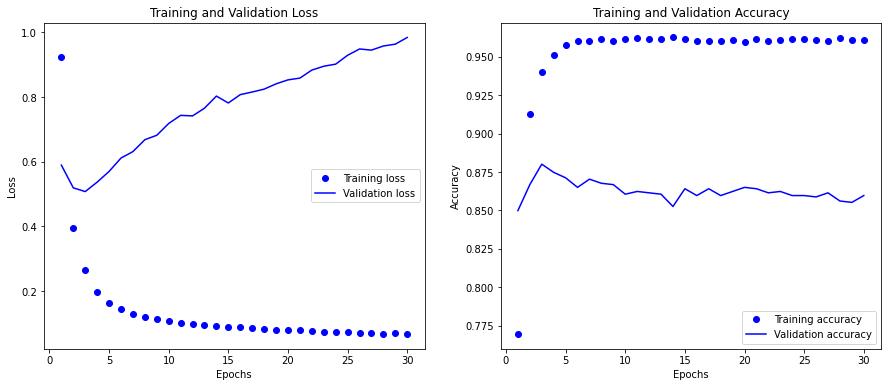

In [0]:
#Model 1
plot_results(performance)

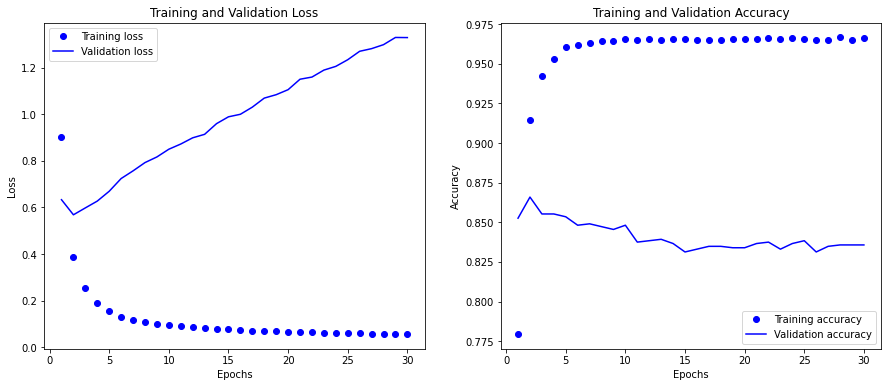

In [0]:
#Model 2
plot_results(performance)

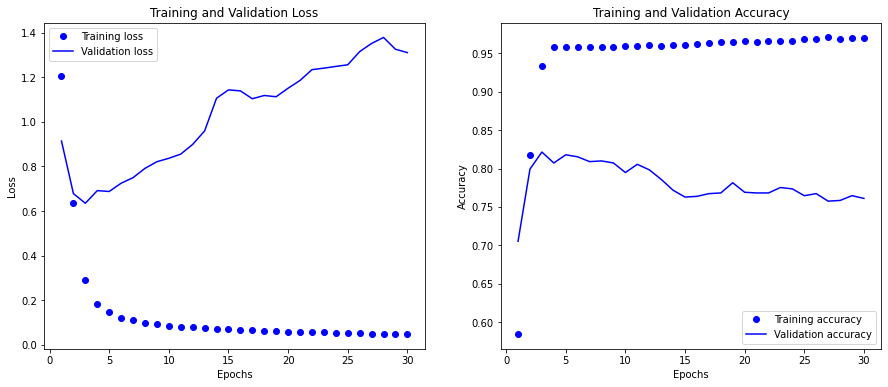

In [0]:
#Model 3
plot_results(performance)

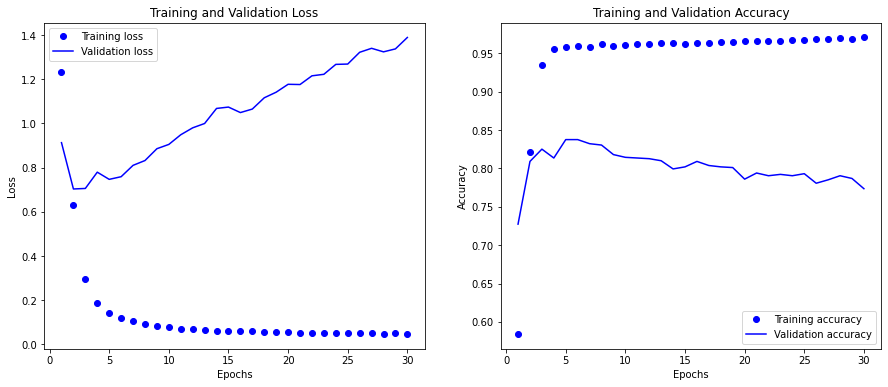

In [0]:
#Model 4
plot_results(performance)

In [0]:
def plot_gradients(grads, layer):

    epochs = len(grads)
    prior_layer_num = sample(range(grads[0][layer].shape[0]),1)
    current_lay_num = range(grads[0][layer].shape[1])
    for current_layer in sample(current_lay_num,5):
        grad = []
        for epoch in range(epochs):
            value = grads[epoch][layer][prior_layer_num][current_layer].numpy()
            grad.append(value)

        plt.plot(grad)

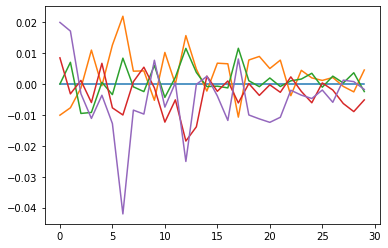

In [0]:
#Model 1 
plot_gradients(grads, 2)

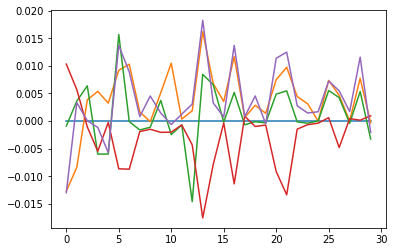

In [0]:
#Model 2
plot_gradients(grads, 2)

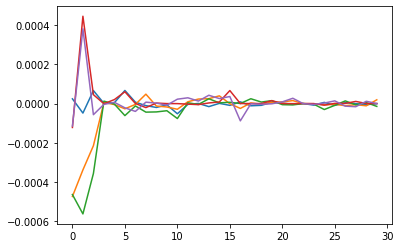

In [0]:
#Model 3 
plot_gradients(grads, 1)

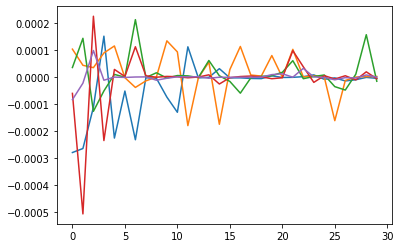

In [0]:
#Model 4
plot_gradients(grads, 1)

In [0]:
def return_final_parameters(model, X):
    
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(X)

    weights = [layer.get_weights() for layer in model.layers]
    return activations, weights

In [0]:
def plot_weights(weight_history, layer, model):
    
    num_weights = np.shape(weight_history[0][layer][0])[0]
    num_neurons = np.shape(weight_history[0][layer][0])[1]
    epochs = len(weight_history)
    weights_to_plot = {}
    num_plots = 5
    fig, ax = plt.subplots(1, num_plots, figsize = [20, 6])
    for axes in range(num_plots):
        for weight in sample(list(np.arange(0, num_weights, 1)), 1):
            for neuron in list(np.arange(0, num_neurons, 1)):
                weight_id = f'N{neuron}_W{weight}'
                weights_to_plot[weight_id] = []
                for epoch in range(epochs-1):
                    weights_to_plot[weight_id].append(weight_history[epoch][layer][0][weight][neuron])
                ax[axes].plot(weights_to_plot[weight_id], label = weight_id)
                # ax[axes].legend()
                ax[axes].set_xlabel('Epoch')
                ax[axes].set_ylabel('Weight Value')
                ax[axes].set_title(f'Weight {weight} Per Neuron and Epoch')

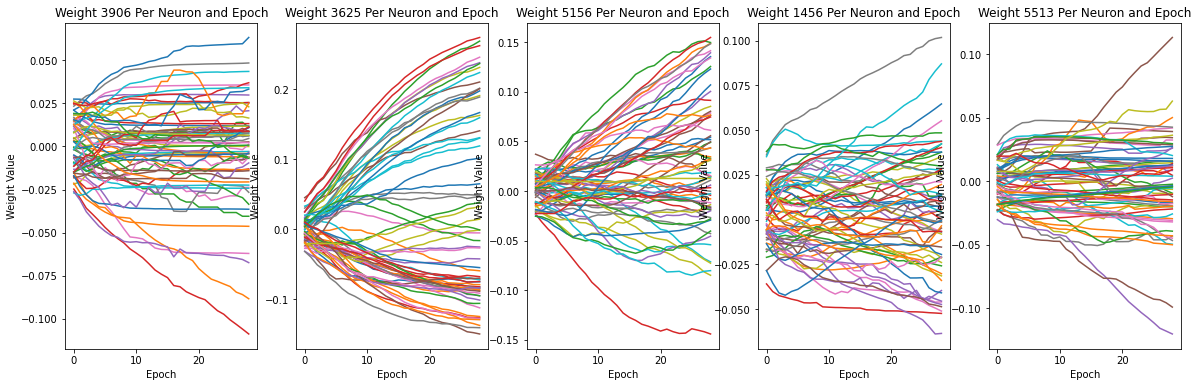

In [0]:
#Model 1
plot_weights(weight_history, 0, model_1)

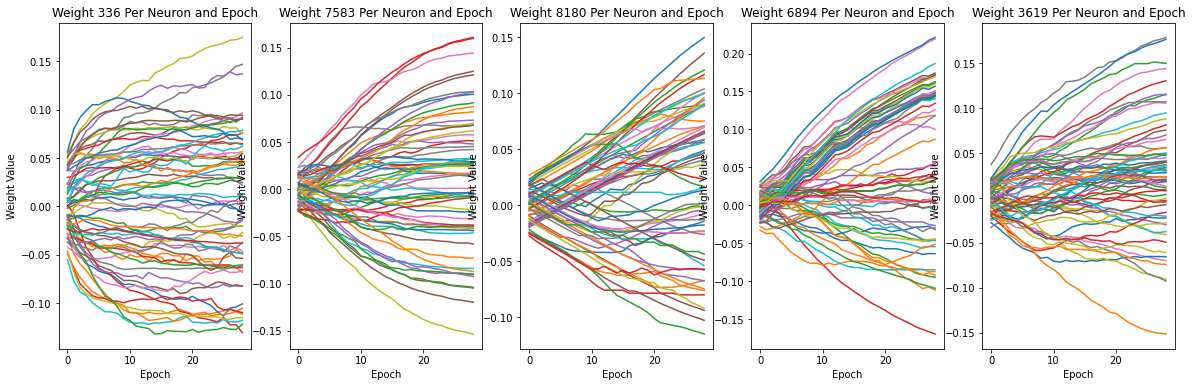

In [0]:
#Model 2
plot_weights(weight_history, 0, model_2)

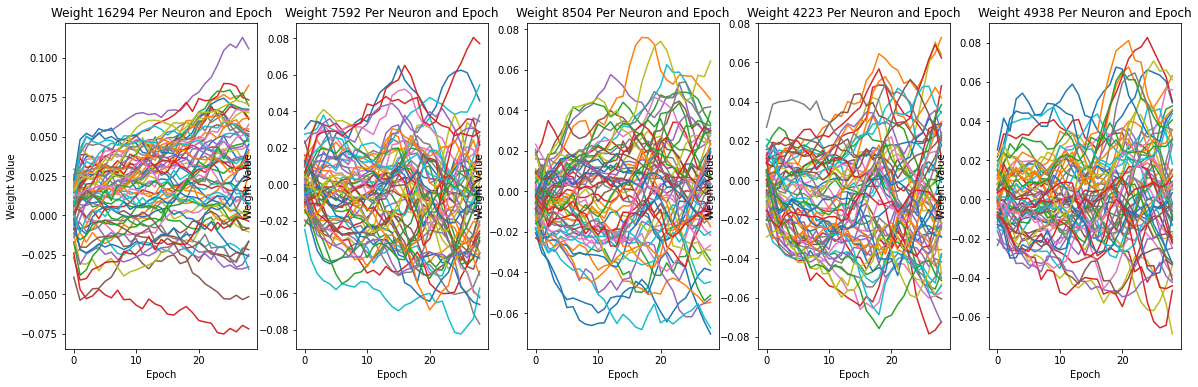

In [0]:
#Model 3
plot_weights(weight_history, 2, model_3)

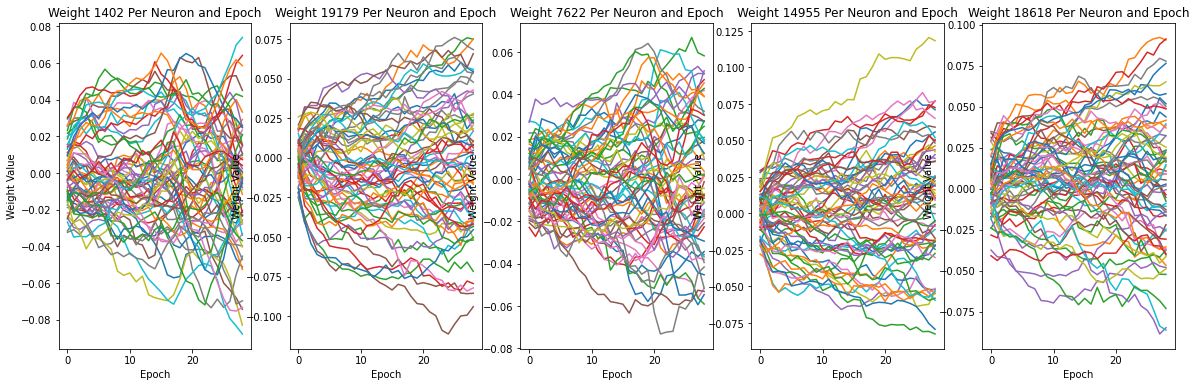

In [0]:
#Model 4
plot_weights(weight_history, 2, model_4)